In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import random
from sklearn.metrics import confusion_matrix, mean_squared_error, log_loss, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
from tensorflow.keras.models import model_from_json
from tensorflow.keras import layers, Model
from tensorflow.keras import optimizers

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)

In [2]:
experi = pd.read_csv('results_clip_cluster_linearTransformation/NN_experiments_with_1.0data.csv')

In [3]:
experi

,best_dev_mse,history,hyperparam
0,0.03609,"{'loss': [0.03920776502457632, 0.037692687256800375, 0.037328493495628376, 0.03710551380247367, ...","{'opt': 'adam', 'fc_hidden_size': 128, 'lr': 0.005793115158586209, 'n_fc_layers': 4}"


In [4]:
experi = experi.sort_values('best_dev_mse', axis=0)

## load the best model to analyze

In [5]:
# best = experiments.loc[experiments['best_dev_mse'] == min(experiments['best_dev_mse'])]
best = experi.iloc[:1,:]
best

,best_dev_mse,history,hyperparam
0,0.03609,"{'loss': [0.03920776502457632, 0.037692687256800375, 0.037328493495628376, 0.03710551380247367, ...","{'opt': 'adam', 'fc_hidden_size': 128, 'lr': 0.005793115158586209, 'n_fc_layers': 4}"


In [6]:
hyp_str = best['hyperparam'].to_list()[0]
hyp = hyp_str.replace("'", "\"")
hyp_params = json.loads(hyp)
hyp_params

{'fc_hidden_size': 128,
 'lr': 0.005793115158586209,
 'n_fc_layers': 4,
 'opt': 'adam'}

In [7]:
h_str = best['history'].to_list()[0]
history = h_str.replace("'", "\"")
hist = json.loads(history)

hist_df = pd.DataFrame(data=hist)
hist_df['epoch'] = range(0, len(hist_df))

best_detail = hist_df.loc[hist_df['val_loss'] == min(hist_df['val_loss'])]
best_detail

,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
16,0.036235,0.036235,0.03609,0.03609,16


In [8]:
Xtrain = np.load('encoded_data_clip_fast/Xtrain.npy')
Xdev = np.load('encoded_data_clip_fast/Xdev.npy')
Xtest = np.load('encoded_data_clip_fast/Xtest.npy')

ytrain = np.load('encoded_data_clip_fast/ytrain.npy')
ydev = np.load('encoded_data_clip_fast/ydev.npy')
ytest = np.load('encoded_data_clip_fast/ytest.npy')

In [64]:
ydev.shape

(13863, 12)

In [9]:
model_n = 0
# load json and create model
model_path = 'results_clip_cluster_linearTransformation/NNmodel_{}_with_1.0data.json'.format(model_n)
print(model_path)
weights_path = 'results_clip_cluster_linearTransformation/NNmodel_{}_with_1.0data_weights.hdf5'.format(model_n)

json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
if hyp_params['opt'] == 'adam':
    opt = optimizers.Adam(lr=hyp_params['lr'])
elif hyp_params['opt'] == 'rmsprop':
    opt = optimizers.RMSprop(lr=hyp_params['lr'])
elif hyp_params['opt'] == 'sgd':
    opt = optimizers.SGD(lr=hyp_params['lr'])
else:
    raise ValueError('Unknown optimizer: {}'.format(hyp_params['opt']))

loaded_model.compile(loss='mean_squared_error', optimizer=opt,
                     metrics=['mean_squared_error'])

W0911 03:17:15.083447 140610080265984 deprecation.py:506] From /data/home/t-chepan/env/newlab/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0911 03:17:15.084619 140610080265984 deprecation.py:506] From /data/home/t-chepan/env/newlab/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0911 03:17:15.085797 140610080265984 deprecation.py:506] From /data/home/t-chepan/env/newlab/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ze

results_clip_cluster_linearTransformation/NNmodel_0_with_1.0data.json
Loaded model from disk


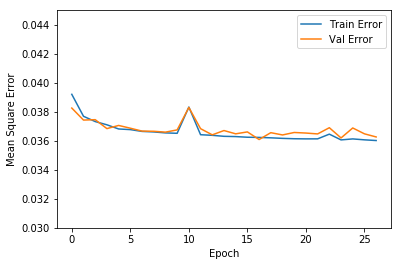

In [10]:
def plot_history(hist_df):
    

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist_df['epoch'], hist_df['mean_squared_error'],
           label='Train Error')
    plt.plot(hist_df['epoch'], hist_df['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0.03,0.045])
    plt.legend()
#     plt.savefig('plots/bestNNmodel_learning_curve.png')
    plt.show()


plot_history(hist_df)



In [11]:
train_pred = loaded_model.predict(Xtrain)
train_mse = mean_squared_error(ytrain, train_pred)
train_mse

0.03580122415673818

In [12]:
dev_pred = loaded_model.predict(Xdev)
dev_mse = mean_squared_error(ydev, dev_pred)
dev_mse

0.036090237673891

In [13]:
test_pred = loaded_model.predict(Xtest)
test_mse = mean_squared_error(ytest, test_pred)
test_mse

0.03570946654132299

## Clustering the mature tenants

In [14]:
features = pd.read_csv('encoded_data_clip_fast/encoded_columns_name.txt', delimiter='\t', header=None)
features.columns = ['cols_name']

outputs_name = [
     'AR_exchange_06',
 'AR_sharepoint_06',
 'AR_skype_06',
 'AR_teams_06',
 'AR_od4b_06',
 'AR_onenote_06',
 'AR_word_06',
 'AR_excel_06',
 'AR_powerpoint_06',
 'AR_outlook_06',
 'AR_eslt_06',
 'AR_officeclient_06'
]

In [15]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  [(None, 446)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               57216     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                36    

In [16]:
output_weights = loaded_model.get_weights()[-2]
output_weights.shape

(2, 12)

In [17]:
output_bias = loaded_model.get_weights()[-1]
output_bias.shape

(12,)

In [18]:
model = loaded_model
last2nd_layer_index = hyp_params['n_fc_layers']+1
last2nd_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(index=last2nd_layer_index).output)

last2nd_layer_output = last2nd_layer_model.predict(Xdev)

last2nd_layer_output.shape

(13863, 2)

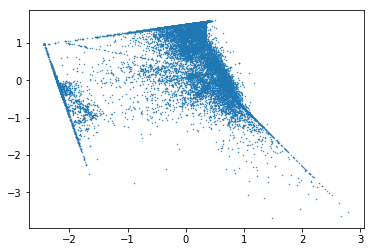

In [36]:
plt.figure()
plt.scatter(x=last2nd_layer_output[:,0], y=last2nd_layer_output[:,1], s=0.2)
# plt.axis('off')
# plt.xticks([])
# plt.yticks([])

In [65]:
def plot_decision_heatmap(f, x, y, name, size=100, save_fn=None, data=None, ids=None):
    sz = size
    x_min, x_max, y_min, y_max = -3, 3, -4, 2
    X,Y = np.meshgrid(np.linspace(x_min,x_max,sz),np.linspace(y_min,y_max,sz))
    grid_inputs = np.vstack([np.reshape(X, -1), np.reshape(Y, -1)]).T

    output = f(grid_inputs)
    G = np.reshape(output, [size, size])
    fig,ax = plt.subplots()
    plt.contourf(X, Y, G, cmap=plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(x, y, 0.1)
    plt.xticks([])
    plt.yticks([])
    plt.title(name)

#     if data is not None and ids is not None:
#         d = data
#         ids = ids
#         plt.scatter(d[:,0][ids==0], d[:,1][ids==0], marker='x', c='blue')
#         plt.scatter(d[:,0][ids==1], d[:,1][ids==1], marker='x', c='r')

#         plt.scatter(few_data[:,0][few_ids==0], few_data[:,1][few_ids==0], marker='x', c='black')
#         plt.scatter(few_data[:,0][few_ids==1], few_data[:,1][few_ids==1], marker='x', c='black')

#     if save_fn:
#         plt.savefig(save_fn)

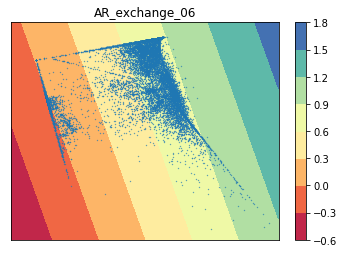

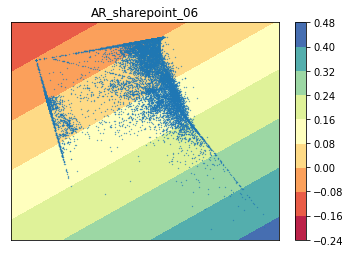

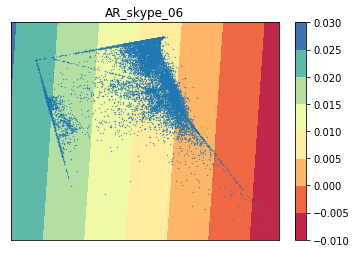

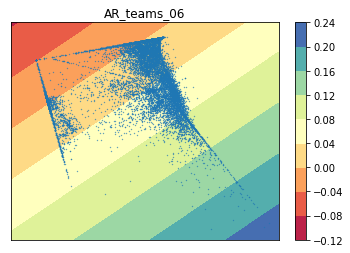

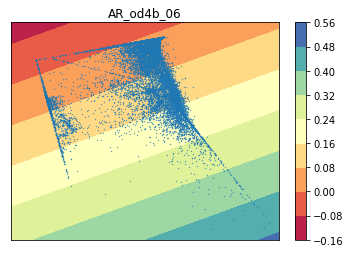

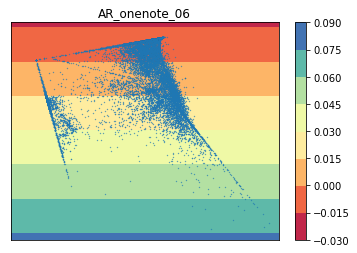

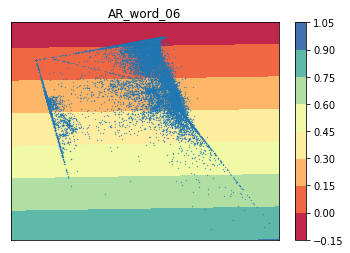

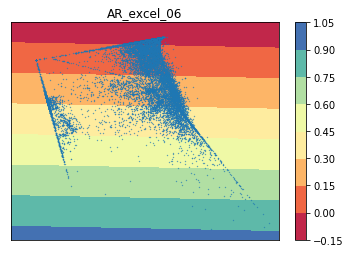

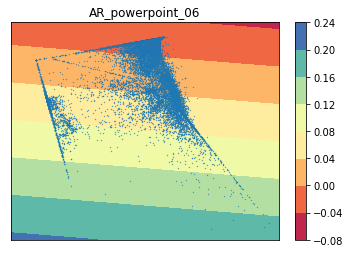

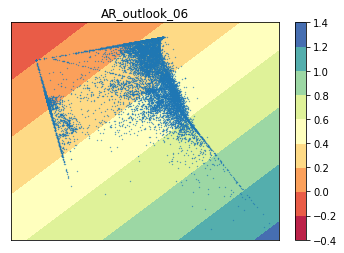

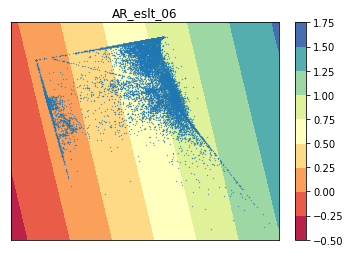

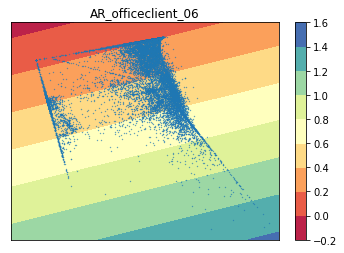

In [66]:
for i_workload in range(12):
    w = output_weights[:,i_workload]
    b = output_bias[i_workload]
    def f(x):
        return x.dot(w) + b
    plot_decision_heatmap(f, last2nd_layer_output[:,0], last2nd_layer_output[:,1], outputs_name[i_workload])

In [22]:
df_dev = pd.read_csv('encoded_data_clip_fast/dev_set_raw_data.csv')
scaler = joblib.load('encoded_data_clip_fast/scaler.pkl')

/data/home/t-chepan/env/newlab/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
from sklearn import cluster, mixture
from itertools import cycle, islice

n_examples = Xdev.shape[0]
X = last2nd_layer_output[:n_examples]
K = 4
np.random.seed(314)
algo = cluster.MiniBatchKMeans(n_clusters=K)
# algo = cluster.SpectralClustering(
#     n_clusters=K, eigen_solver='arpack',
#     affinity="nearest_neighbors")

algo = mixture.GaussianMixture(
    n_components=K, covariance_type='full')

%time algo.fit(X)
if hasattr(algo, 'labels_'):
    y_pred = algo.labels_.astype(np.int)
else:
    y_pred = algo.predict(X)


CPU times: user 158 ms, sys: 0 ns, total: 158 ms
Wall time: 157 ms


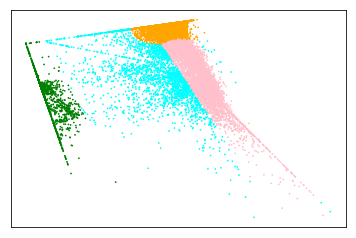

In [48]:
# colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
#                                      '#f781bf', '#a65628', '#984ea3',
#                                      '#999999', '#e41a1c', '#dede00']),
#                               int(max(y_pred) + 1))))
# # add black color for outliers (if any)
colors = np.array(['aqua', 'green', 'orange', 'pink'])
# colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=0.5, color=colors[y_pred])
plt.xticks([])
plt.yticks([])
plt.savefig('plots/2d_NN_cluster.png')

In [25]:
# df_dev[:n_examples][y_pred == 0]


In [26]:
df_dev.head()
features = pd.read_csv('encoded_data_clip_fast/encoded_columns_name.txt', delimiter='\t', header=None)
features.columns = ['feature_name']
feature_name_dict = features.to_dict()['feature_name']
rev_feature_name_dict = dict([(v, k) for k, v in feature_name_dict.items()])

In [27]:
important_feature_names = ['PaidCount',
 'EXOEnabledUsers',
 'PPDEnabledUsers',
 'PaidEXOSeats',
 'CountryCode=US',
 'PaidProplusSeats',
 'Languange=en',
 'PaidOD4BSeats',
 'SfBSubscriptionsCount',
 'TotalUsers',
 'AllupSeats',
 'EXOSubscriptionsCount',
 'TeamEnabledUsers',
 'CountryCode=GB',
 'HasEXO',
 'PaidKaizalaSeats',
 'FirstPaidEXOStartDate',
 'FirstPaidOD4BStartDate',
 'TopParents_Industry=0',
 'CountryCode=DE',
 'O365EnabledUsers',
 'FirstPaidProPlusStartDate',
 'CountryCode=NL',
 'OD4BEnabledUsers',
 'TeamsSubscriptionsCount',
 'NonTrialSubscriptionsCount',
 'PaidSPOSeats',
 'ActivatedSubscriptionTotalCount',
 'OD4BSubscriptionsCount',
 'SPOEnabledUsers',
 'CountryCode=AU',
 'PaidSFBSeats',
 'Languange=de',
 'HasSPO',
 'CountryCode=CA',
 'Languange=es',
 'HasOD4B',
 'M365EnabledUsers',
 'YammerEnabledUsers',
 'CountryCode=FR']

industry_feature_names = ['TopParents_Industry=0',
 'TopParents_Industry=Partner Professional Services',
 'TopParents_Industry=Smart Spaces',
 'TopParents_Industry=Consumer Goods',
 'TopParents_Industry=Professional Services',
 'TopParents_Industry=Health Provider',
 'TopParents_Industry=Retailers',
 'TopParents_Industry=Nonprofit',
 'TopParents_Industry=Other - Unsegmented',
 'TopParents_Industry=Discrete Manufacturing',
 'TopParents_Industry=Media & Entertainment',
 'TopParents_Industry=Chemicals & Agrochemicals',
 'TopParents_Industry=National Government',
 'TopParents_Industry=Telecommunications',
 'TopParents_Industry=Banking & Capital Markets',
 'TopParents_Industry=Primary & Secondary Edu/K-12',
 'TopParents_Industry=Travel & Transportation',
 'TopParents_Industry=Insurance',
 'TopParents_Industry=Higher Education',
 'TopParents_Industry=Energy',
 'TopParents_Industry=Automotive',
 'TopParents_Industry=Local Regional Government',
 'TopParents_Industry=Health Payor',
 'TopParents_Industry=Pharmaceuticals',
 'TopParents_Industry=Defense & Intelligence',
 'TopParents_Industry=Gaming',
 'TopParents_Industry=Forestry & Fishing',
 'TopParents_Industry=Libraries & Museums']

In [28]:
# df_young = pd.read_csv('results_clip_fast/rec_display_youngTenants_Hackathon_0.05threshold.csv')
Xyoung = np.load('encoded_data_clip_fast/Xyoung.npy')
yyoung = np.load('encoded_data_clip_fast/yyoung.npy')


In [29]:
# df_young.head(100)
# df_young_sorted = df_young.sort_values(by=['AR_exchange_06'], ascending=False)
# df_young_selected = df_young_sorted.loc[
#     (df_young_sorted['AR_exchange_06'] > 0.49) & (df_young_sorted['AR_exchange_06'] < 0.5) &
# (df_young_sorted['AR_exchange_06_delta'] > 0.4)]

# df_young_selected_0 = df_young_sorted.loc[
#     (df_young_sorted['AR_exchange_06'] > 0.49) & (df_young_sorted['AR_exchange_06'] < 0.5) &
# (df_young_sorted['AR_exchange_06_delta'] < 0.01) & (df_young_sorted['AR_exchange_06_delta'] > 0.0)]
# df_young_selected_0
# small_delta_index = df_young_selected_0.index.tolist()
# Xyoung_small_delta = Xyoung[small_delta_index]
# scaler.inverse_transform(Xyoung_small_delta)

In [38]:
Xyoun_last2nd = last2nd_layer_model.predict(Xyoung)

Xyoung_pred = Xyoun_last2nd.dot(output_weights) + output_bias

young_exo_delta = (Xyoung_pred - yyoung)[:, 0]
young_exo_true = yyoung[:,0]
young_exo_pred = young_pred[:,0]
young_exo_data = np.concatenate(
    [np.reshape(a, [young_exo_true.shape[0], 1]) for a in [young_exo_true, young_exo_pred, young_exo_delta]],
    axis=1)

In [39]:
small_delta_indices = []
for i in range(young_exo_data.shape[0]):
    delta = young_exo_data[i][2]
    true = young_exo_data[i][0]
    pred =  young_exo_data[i][1]
    if ((true < 0.5 and true > 0.49) and 
        (delta < 0.01 and delta > 0.0)):
        small_delta_indices.append(i)
        
large_delta_indices = []
for i in range(young_exo_data.shape[0]):
    delta = young_exo_data[i][2]
    true = young_exo_data[i][0]
    pred =  young_exo_data[i][1]
    if ((true < 0.5 and true > 0.49) and 
        (delta > 0.4)):
        large_delta_indices.append(i)

small_selected_data = Xyoun_last2nd[small_delta_indices]
large_selected_data = Xyoun_last2nd[large_delta_indices]


In [40]:
df_young = pd.read_csv('raw_data/TenantInfo-and-usage_shuffled_inf_clip_young.csv')

In [62]:
df_young.loc[small_delta_indices, ['TenantId','CountryCode','TopParents_Industry','AllupSeats']]

,TenantId,CountryCode,TopParents_Industry,AllupSeats
204300,ED72290E-1DC9-4FA8-B16F-2E8259A29D4B,DE,Partner Professional Services,10
214917,90F457C1-41EA-4DF8-9A86-E67DBF41D6CB,US,Banking & Capital Markets,30
266838,8779CAA1-68D5-4BBD-8074-5A7AD7A2B557,AU,Partner Professional Services,29
303202,70A4C086-C398-4671-8A98-CEB8A47A51BB,US,National Government,27
365412,8F7D877C-9562-4125-836F-D3BF4B19181F,FR,Professional Services,20
373194,BB96E7FC-2F07-4483-8380-0978FA896414,CA,0,6
451747,92C92BB3-218D-49A7-BC44-29A04929B2FD,US,0,19
452798,02812A93-D21D-483B-920E-5D297288F11D,US,Retailers,23


In [63]:
df_young.loc[large_delta_indices, ['TenantId','CountryCode','TopParents_Industry','AllupSeats']]

,TenantId,CountryCode,TopParents_Industry,AllupSeats
3902,78203907-E5C2-493C-9389-7CE48EC1607E,NZ,Partner Professional Services,13
61053,FE1F7F5D-2753-41D5-8572-EC45E0E75858,NZ,0,10
147159,635D9E30-11BE-4ABA-B065-8119231E24EA,CO,0,59
218883,816926BA-C122-4F82-9C58-F348BF37946F,US,Professional Services,245
233546,D1B51BCA-9EAF-49D3-A7C1-6B9C163B4967,CA,0,28
321301,0831A0D5-BBD3-4270-BC85-85B1F9BFE298,CA,0,157


In [41]:
df_young.loc[small_delta_indices[0],important_feature_names+['CountryCode', 'TopParents_Industry', 'TenantId']]

/data/home/t-chepan/env/newlab/lib/python3.5/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


PaidCount                                                            10
EXOEnabledUsers                                                       7
PPDEnabledUsers                                                       7
PaidEXOSeats                                                         10
CountryCode=US                                                      NaN
PaidProplusSeats                                                     10
Languange=en                                                        NaN
PaidOD4BSeats                                                        10
SfBSubscriptionsCount                                                 1
TotalUsers                                                            8
AllupSeats                                                           10
EXOSubscriptionsCount                                                 1
TeamEnabledUsers                                                      0
CountryCode=GB                                                  

In [42]:
df_young.loc[large_delta_indices[0],important_feature_names+['CountryCode', 'TopParents_Industry', 'TenantId']]

PaidCount                                                            12
EXOEnabledUsers                                                      13
PPDEnabledUsers                                                      12
PaidEXOSeats                                                         12
CountryCode=US                                                      NaN
PaidProplusSeats                                                     12
Languange=en                                                        NaN
PaidOD4BSeats                                                        12
SfBSubscriptionsCount                                                 2
TotalUsers                                                           19
AllupSeats                                                           13
EXOSubscriptionsCount                                                 2
TeamEnabledUsers                                                     13
CountryCode=GB                                                  

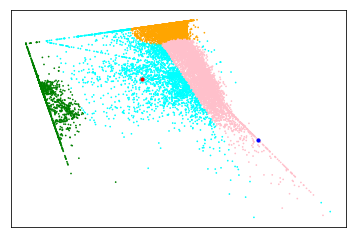

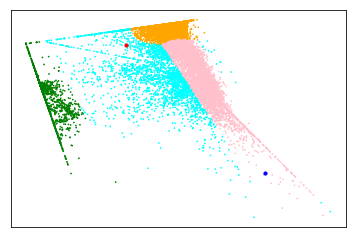

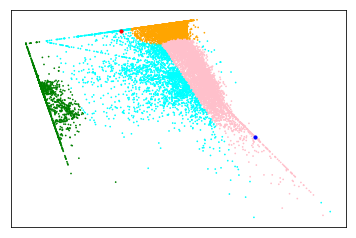

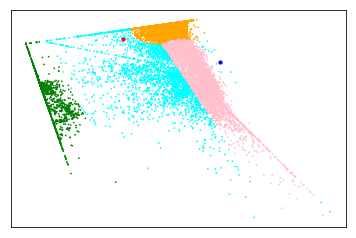

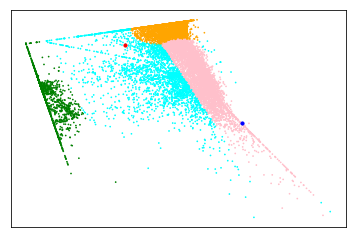

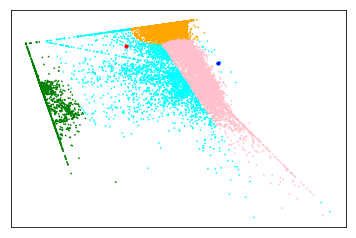

In [61]:
for i in range(6):
    colors = np.array(['aqua', 'green', 'orange', 'pink'])
    # add black color for outliers (if any)
    # colors = np.append(colors, ["black"])
    plt.scatter(X[:, 0], X[:, 1], s=0.5, color=colors[y_pred])
    plt.scatter(small_selected_data[i:i+1,0], small_selected_data[i:i+1,1], s=10, color='red')
    plt.scatter(large_selected_data[i:i+1,0], large_selected_data[i:i+1,1], s=10, color='blue')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [49]:
# Xdev_unscaled = X
Xdev_unscaled = scaler.inverse_transform(Xdev)
# centers = algo.cluster_centers_
centers = algo.means_
center_usage = centers.dot(output_weights) + output_bias

In [52]:
for i in range(center_usage.shape[0]):
    print('=' * 50)
    print('cluster {}'.format(i))
    cluster_X = Xdev[:n_examples][y_pred == i]
    cluster_true_usage = ydev[:n_examples][y_pred == i]
    mean_cluster_true_usage = np.mean(cluster_true_usage, axis=0)
    std_cluster_true_usage = np.std(cluster_true_usage, axis=0) #/ np.sqrt(cluster_true_usage.shape[0])

    mean_features = np.mean(cluster_X, axis=0)
    std_features = np.std(cluster_X, axis=0) / np.sqrt(cluster_X.shape[0])
    print(cluster_X.shape[0])
    print(cluster_X.shape[0] * 1.0 / n_examples)
    for k, name in enumerate(outputs_name):
        print(': {0:.2f} +- {1:.2f}'.format(#name[3:8],
                                            mean_cluster_true_usage[k], std_cluster_true_usage[k]))
    print('*' * 25)
    for fn in important_feature_names:
        i_feature = rev_feature_name_dict[fn]
        if (mean_features[i_feature] - std_features[i_feature] * 2) > 0.0:
            print('{0}: {1:.4f} +- {2:.4f}'.format(fn, mean_features[i_feature], std_features[i_feature]))

cluster 0
2840
0.20486186251172184
: 0.56 +- 0.38
: 0.06 +- 0.18
: 0.01 +- 0.05
: 0.04 +- 0.14
: 0.11 +- 0.22
: 0.02 +- 0.08
: 0.21 +- 0.23
: 0.22 +- 0.24
: 0.04 +- 0.11
: 0.38 +- 0.32
: 0.57 +- 0.34
: 0.45 +- 0.32
*************************
PPDEnabledUsers: 0.0580 +- 0.0207
PaidEXOSeats: 0.0481 +- 0.0213
CountryCode=US: 0.0592 +- 0.0190
PaidProplusSeats: 0.0639 +- 0.0208
PaidOD4BSeats: 0.0662 +- 0.0216
SfBSubscriptionsCount: 0.2734 +- 0.0144
AllupSeats: 0.0457 +- 0.0209
EXOSubscriptionsCount: 0.0515 +- 0.0158
TeamEnabledUsers: 0.0667 +- 0.0162
HasEXO: 0.3324 +- 0.0073
PaidKaizalaSeats: 0.1278 +- 0.0234
FirstPaidEXOStartDate: 0.3156 +- 0.0088
FirstPaidOD4BStartDate: 0.2943 +- 0.0120
CountryCode=DE: 0.0809 +- 0.0218
FirstPaidProPlusStartDate: 0.3577 +- 0.0149
TeamsSubscriptionsCount: 0.2634 +- 0.0144
NonTrialSubscriptionsCount: 0.1323 +- 0.0224
PaidSPOSeats: 0.1326 +- 0.0232
ActivatedSubscriptionTotalCount: 0.1456 +- 0.0225
OD4BSubscriptionsCount: 0.1837 +- 0.0173
SPOEnabledUsers: 0.0666

In [ ]:
for i in range(center_usage.shape[0]):
    print('=' * 50)
    print('cluster {}'.format(i))
    cluster_X = Xdev[:n_examples][y_pred == i]
    mean_features = np.mean(cluster_X, axis=0)
    print(cluster_X.shape[0])
    print(cluster_X.shape[0] * 1.0 / n_examples)
    for k, name in enumerate(outputs_name):
        print('{0}: {1:.2f}%'.format(name, np.maximum(center_usage[i,k]*100, 0.0)))
    print('*' * 25)
    for fn in industry_feature_names:
        i_feature = rev_feature_name_dict[fn]
        if mean_features[i_feature] > 0.02:
            print('{0}: {1:.4f}'.format(fn, mean_features[i_feature]))
    

In [ ]:

for k, name in enumerate(outputs_name):
    print('=' * 50)
    print('workload {}'.format(name))
    for i in range(center_usage.shape[0]):
        print('{1}: {0:.2f}%'.format(np.maximum(center_usage[i,k]*100, 0.0), i))

In [ ]:
center_usage = centers.dot(output_weights) + output_bias
for i in range(center_usage.shape[0]):
    print('=' * 50)
    print('center {}'.format(i))
    for k, name in enumerate(outputs_name):
        print('{0}: {1:.2f}%'.format(name, np.maximum(center_usage[i,k]*100, 0.0)))

In [ ]:
dev_pred[0][i_workload]

In [ ]:
last2nd_layer_output[0].dot(w) + b

In [ ]:
ydev.shape

In [ ]:
X = intermediate_output
# sc = StandardScaler()  
# X = sc.fit_transform(intermediate_output)

distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300, metric="precomputed")
tsne_results = tsne.fit_transform(distance_matrix)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
# data = pd.DataFrame(data=X, columns=[i for i in range(intermediate_output.shape[1])])
data = pd.read_csv('encoded_data_clip_fast/dev_set_raw_data.csv')
cols = data.columns.tolist()

In [ ]:
cols[-12:]

In [ ]:
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    #hue="target",
    #palette=sns.color_palette("hls", 2),
    data=data,
    legend="full",
    alpha=0.3
)
# plt.savefig('plots/1per-cluster-tsne-profile.png')

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
data['pca-one'] = pca_result[:,0]
data['pca-two'] = pca_result[:,1] 
data['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
#     hue="target",
    palette=sns.color_palette("hls", 2),
    data=data,
    legend="full",
    alpha=0.3
)
# plt.savefig('plots/1per-cluster-pca-profile.png')

In [ ]:
model_n = 0

In [ ]:
model = loaded_model
last_hiden_layer_index = 4
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(index=last_hiden_layer_index).output)

intermediate_output = intermediate_layer_model.predict(Xdev)

In [ ]:
intermediate_output.shape

In [ ]:
output_weights = model.get_weights()[-2]

In [ ]:
# model_n = best.index
# model_n = model_n[0]
model_n = 0

In [ ]:
intermediate_output

## How is the performance on purchased workloads?

In [ ]:
features = pd.read_csv('encoded_data_clip_fast/encoded_columns_name.txt', delimiter='\t', header=None)
features.columns = ['cols_name']

outputs_name = [
     'AR_exchange_06',
 'AR_sharepoint_06',
 'AR_skype_06',
 'AR_teams_06',
 'AR_od4b_06',
 'AR_onenote_06',
 'AR_word_06',
 'AR_excel_06',
 'AR_powerpoint_06',
 'AR_outlook_06',
 'AR_eslt_06',
 'AR_officeclient_06'
]

In [ ]:
features[:80]

In [ ]:
total_index = features.loc[features['cols_name'] == 'PaidCount'].index
exo_index = features.loc[features['cols_name'] == 'PaidEXOSeats'].index
spo_index = features.loc[features['cols_name'] == 'PaidSPOSeats'].index
od4b_index = features.loc[features['cols_name'] == 'PaidOD4BSeats'].index
teams_index = features.loc[features['cols_name'] == 'PaidTeamsSeats'].index
sfb_index = features.loc[features['cols_name'] == 'PaidSFBSeats'].index
office_index = features.loc[features['cols_name'] == 'PaidOfficeSeats'].index

In [ ]:
Xdev[:,exo_index].shape


In [ ]:
# outputs_name

In [ ]:
mask_exo = np.where(Xdev[:,exo_index] > 0, 1, 0)
# mask_exo = mask_exo.reshape(Xdev.shape[0], 1)
mask_exo.shape

In [ ]:
mask_spo = np.where(Xdev[:,spo_index] > 0, 1, 0)
mask_sfb = np.where(Xdev[:,sfb_index] > 0, 1, 0)
mask_teams = np.where(Xdev[:,teams_index] > 0, 1, 0)
mask_od4b = np.where(Xdev[:,od4b_index] > 0, 1, 0)
mask_eslt = np.where(Xdev[:,total_index] > 0, 1, 0)
mask_office = np.where(Xdev[:,office_index] > 0, 1, 0)

In [ ]:
mask_office_all = np.ones((Xdev.shape[0], 5))

for i in range(5):
    mask_office_all[:,i] = mask_office[:,0]
    

In [ ]:
mask_office_all.sum() == mask_office.sum() * 5

In [ ]:
mask = np.concatenate([mask_exo, mask_spo, mask_sfb, mask_teams, mask_od4b, 
                       mask_office_all, mask_eslt, mask_office], axis=1)

In [ ]:
mask.shape

In [ ]:
squared_error = np.square(dev_pred - ydev)

In [ ]:
purchased_workload_mse_multi = np.sum(mask * squared_error, axis=0) / np.sum(mask, axis=0)

In [ ]:
purchased_workload_mse_multi

In [ ]:
purchased_workload_ = {}

for i, n in enumerate(outputs_name):
    
    purchased_workload_[n] = purchased_workload_mse_multi[i]
    
s = pd.Series(purchased_workload_).sort_values()

print(s)

In [ ]:
purchased_workload_mse = np.mean(purchased_workload_mse_multi)
purchased_workload_mse

In [ ]:
purchased_workload_std_multi = np.std((dev_pred - ydev), axis=0)
purchased_workload_std_multi

In [ ]:
purchased_workload_rmse_multi = np.sqrt(purchased_workload_mse_multi)
purchased_workload_rmse_multi

In [ ]:
rmse_std_multi = (purchased_workload_rmse_multi / purchased_workload_std_multi).reshape((12,1))
purchased_workload_std_multi = purchased_workload_std_multi.reshape((12,1))

purchased_workload_rmse_multi = purchased_workload_rmse_multi.reshape((12,1))
purchased_workload_mse_multi = purchased_workload_mse_multi.reshape((12,1))

rmse_data = np.concatenate((purchased_workload_mse_multi, purchased_workload_rmse_multi,
                            purchased_workload_std_multi, rmse_std_multi), axis=1)

In [ ]:
purchased_wl_rmse_multi_df = pd.DataFrame(data=rmse_data, columns=['mse', 'rmse', 'std', 'rmse/std'],
                                          index=outputs_name)
purchased_wl_rmse_multi_df

## Simply use mean to predict the usage, what's the mse? 

In [ ]:
ydev.shape

In [ ]:
ytrain.shape

In [ ]:
mean_pred = np.mean(ytrain, axis=0)
mean_pred.shape

In [ ]:
mean_mse = np.mean(np.square(ydev - mean_pred))
mean_mse

In [ ]:
mean_mse_multi = np.mean(np.square(ydev - mean_pred), axis=0)
mean_mse_multi

In [ ]:
mean_mse_workload_ = {}

for i, n in enumerate(outputs_name):
    
    mean_mse_workload_[n] = mean_mse_multi[i]
    
s = pd.Series(mean_mse_workload_).sort_values()

print(s)

## Demo

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pickle as pkl
import joblib
import encoding_data

In [ ]:
examples = pd.read_csv('data/dev_set_raw_data.csv')
#examples.head(10)

In [ ]:
examples.head()

In [ ]:
examples.info()

In [ ]:
example_df = examples.iloc[1:2, :].copy()

In [ ]:
df_X, df_y = encoding_data.separate_input_output_cols(example_df, predict_ahead=0, previous_usage=0)

In [ ]:
X_scal, _ = encoding_data.encode_dev_test_inputs(df_X, dv, scaler)

In [ ]:
324 + 62 + 55 + 40 + 8

In [ ]:
dv_file = '/data/home/t-chepan/projects/MS-intern-project/data/vectorizer.pkl' 
scaler_file = '/data/home/t-chepan/projects/MS-intern-project/data/scaler.pkl'
# default_example = {}
dv = joblib.load(dv_file)
scaler = joblib.load(scaler_file)

def encode_input(df, dv, scaler):
    df_X, df_y = encoding_data.separate_input_output_cols(df, predict_ahead=0, previous_usage=0)
    X_scal, _ = encoding_data.encode_dev_test_inputs(df_X, dv, scaler)
    print(X_scal.shape)
    return X_scal, df_y

def decode_output(output, names):
    usage_pattern = {}
    for i, name in enumerate(names):
        usage_pattern[name] = output[i]
    return usage_pattern

def predict_usage_pattern(model, example_df, dv, workload_names, scaler):
    example_input, df_y = encode_input(example_df, dv, scaler)
    output = model.predict(example_input)
    usage_pattern = decode_output(output[0], workload_names)
    return usage_pattern, df_y


# def display(usage_pattern):
#     for k, v in usage_pattern.items():
#         print('workload: {}, usage: {}'.format(k, v))
        

In [ ]:
example_df = examples.iloc[1:2, :].copy()

usage_pattern, df_y = predict_usage_pattern(loaded_model, example_df, dv, outputs_name, scaler)
usage_pattern

# display(usage_pattern)
# lists = sorted(usage_pattern.items()) # sorted by key, return a list of tuples

# x, y = zip(*lists) # unpack a list of pairs into two tuples

# plt.bar(x, y)
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
set(df_train['TopParents_Industry'])

In [ ]:
example_df['AllupSeats'] = 200
example_df['CountryCode'] = 'US'
# example_df['TopParents_Industry'] = '0'

example_df['TopParents_Industry'] = 'Telecommunications'


usage_pattern, df_y = predict_usage_pattern(loaded_model, example_df, dv, outputs_name, scaler)
print(usage_pattern)

lists = sorted(usage_pattern.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

In [ ]:
example_df['AllupSeats'] = 200
example_df['PaidPhoneSystemSeats'] = 200
example_df['CountryCode'] = 'LU'
example_df['TopParents_Industry'] = 'Health Provider'
# example_df['TopParents_Industry'] = 'Telecommunications'


usage_pattern, df_y = predict_usage_pattern(loaded_model, example_df, dv, outputs_name, scaler)
print(usage_pattern)

lists = sorted(usage_pattern.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

In [ ]:
example_df['AllupSeats'] = 20
example_df['CountryCode'] = 'US'
example_df['TopParents_Industry'] = 'Banking & Capital Markets'

usage_pattern, df_y = predict_usage_pattern(loaded_model, example_df, dv, outputs_name, scaler)
print(usage_pattern)

lists = sorted(usage_pattern.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

In [ ]:
## original default example
example_df = df_train.iloc[2:3, :].copy()
example_df

In [ ]:
example_df['CountryCode'] = 'UK'

In [ ]:
def separate_input_output_cols(df):
    cols_name = pd.Series(data=df.columns)

    ar_04_beg_col_index = cols_name[cols_name == 'AR_exchange_04'].index[0]
    ar_06_beg_col_index = cols_name[cols_name == 'AR_exchange_06'].index[0]
    ar_06_end_col_index = cols_name[cols_name == 'AR_officeclient_06'].index[0]

    wl_AR_cols = cols_name[ar_04_beg_col_index:ar_06_end_col_index+1].tolist()

    output_cols = cols_name[ar_06_beg_col_index:ar_06_end_col_index+1].tolist()

    y = df.loc[:, output_cols]

    X = df.drop(columns=wl_AR_cols) # use profile only

    return X, y

In [ ]:
dv_file = '/data/home/t-chepan/projects/MS-intern-project/results/vectorizer.pkl' 
scaler_file = '/data/home/t-chepan/projects/MS-intern-project/results/scaler.pkl'
default_example = {}
dv = joblib.load(dv_file)
scaler = joblib.load(scaler_file)

def encode_input(df, dv, scaler):
    df_X, df_y = separate_input_output_cols(df)
    X_arr = encoding_data.encode_dev_test_inputs(
        df_X, dv, 'demo')
    return scaler.transform(X_arr), df_y

def decode_output(output, names):
    usage_pattern = {}
    for i, name in enumerate(names):
        usage_pattern[name] = output[i]
    return usage_pattern

def predict_usage_pattern(model, example_df, dv, workload_names, scaler):
    example_input, df_y = encode_input(example_df, dv, scaler)
    output = model.predict(example_input)
    usage_pattern = decode_output(output[0], workload_names)
    return usage_pattern, df_y


def display(usage_pattern):
    for k, v in usage_pattern.items():
        print('workload: {}, usage: {}'.format(k, v))
        

example_df = df_test.iloc[4:5, :]

usage_pattern, df_y = predict_usage_pattern(loaded_model, example_df, dv, outputs_name, scaler)

display(usage_pattern)

In [ ]:
y = list(df_y.values[0])

cols = df_y.columns.to_list()


acr_usage_pattern = {}
for i in range(len(y)):
    acr_usage_pattern[cols[i]] = y[i]

lists = sorted(acr_usage_pattern.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()    

In [ ]:
# example_df['AllupSeats'] = 3

# usage_pattern = predict_usage_pattern(
#     loaded_model, example_df, dv, outputs_name, scaler)
# display(usage_pattern)

# lists = sorted(usage_pattern.items()) # sorted by key, return a list of tuples

# x, y = zip(*lists) # unpack a list of pairs into two tuples

# plt.bar(x, y)
# plt.xticks(rotation=90)
# plt.show()


In [ ]:
example_df.columns